# Классификация древних языков с помощью VGG16

In [ ]:
import os
from google.colab import files
from fastai import *
from fastai.vision import *
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!cp -r /content/gdrive/'My Drive'/new_dataset.zip .

In [ ]:
!unzip new_dataset.zip

Archive:  new_dataset.zip
   creating: new_dataset/
   creating: new_dataset/test/
   creating: new_dataset/test/ancient_south_arabian/
  inflating: new_dataset/test/ancient_south_arabian/00094998_001.jpg  
  inflating: new_dataset/test/ancient_south_arabian/mid_00089349_001.jpg  
  inflating: new_dataset/test/ancient_south_arabian/mid_00124256_001.jpg  
  inflating: new_dataset/test/ancient_south_arabian/mid_00126425_001.jpg  
  inflating: new_dataset/test/ancient_south_arabian/mid_00128057_001.jpg  
  inflating: new_dataset/test/ancient_south_arabian/mid_00309773_001.jpg  
  inflating: new_dataset/test/ancient_south_arabian/mid_00311736_001.jpg  
  inflating: new_dataset/test/ancient_south_arabian/mid_00313662_001.jpg  
  inflating: new_dataset/test/ancient_south_arabian/mid_00315693_001.jpg  
  inflating: new_dataset/test/ancient_south_arabian/mid_00315815_001.jpg  
  inflating: new_dataset/test/ancient_south_arabian/mid_00318762_001.jpg  
  inflating: new_dataset/test/ancient_south

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 753.4 MB 6.4 kB/s 
     |████████████████████████████████| 4.0 MB 6.2 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.4.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.4.0 which is incompatible.


### Обучение нейросети

In [ ]:
bs=16
np.random.seed(2)
os.chdir('/content')

In [ ]:
data_path = "./new_dataset/"
data = ImageDataBunch.from_folder(data_path, ds_tfms=get_transforms(), size=299, bs=bs, num_workers=0).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.vgg16_bn, metrics=accuracy, path=".")

In [ ]:
learn.fit_one_cycle(9)

epoch,train_loss,valid_loss,accuracy,time
0,2.418987,1.039334,0.660714,00:42
1,1.713355,0.569172,0.848214,00:42
2,1.280175,0.571112,0.830357,00:42
3,0.963850,0.472038,0.839286,00:42
4,0.731038,0.389171,0.875000,00:42
5,0.601423,0.339277,0.910714,00:41
6,0.515528,0.370268,0.875000,00:42
7,0.430338,0.332518,0.892857,00:42
8,0.353890,0.337846,0.892857,00:42


In [ ]:
learn.save('stage-1')

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


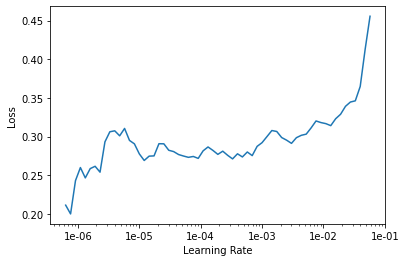

In [ ]:
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.288318,0.325993,0.883929,00:46
1,0.280256,0.305445,0.910714,00:45
2,0.264751,0.303940,0.910714,00:46
3,0.226861,0.287492,0.901786,00:46


In [ ]:
learn.save('stage-2')

In [ ]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.158437,0.289359,0.901786,00:46
1,0.165398,0.276608,0.919643,00:45


In [ ]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.170140,0.273867,0.919643,00:46
1,0.153765,0.265908,0.928571,00:45


In [ ]:
learn.save('stage-3')

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.160315,0.260498,0.928571,00:46
1,0.133392,0.257500,0.928571,00:46
2,0.111186,0.273457,0.919643,00:46
3,0.113174,0.266945,0.910714,00:46
4,0.129863,0.261693,0.910714,00:46


In [ ]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.103622,0.256664,0.919643,00:46
1,0.100143,0.246124,0.946429,00:46


In [ ]:
learn.save('stage-4')

### Результаты

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)


losses,idxs=interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

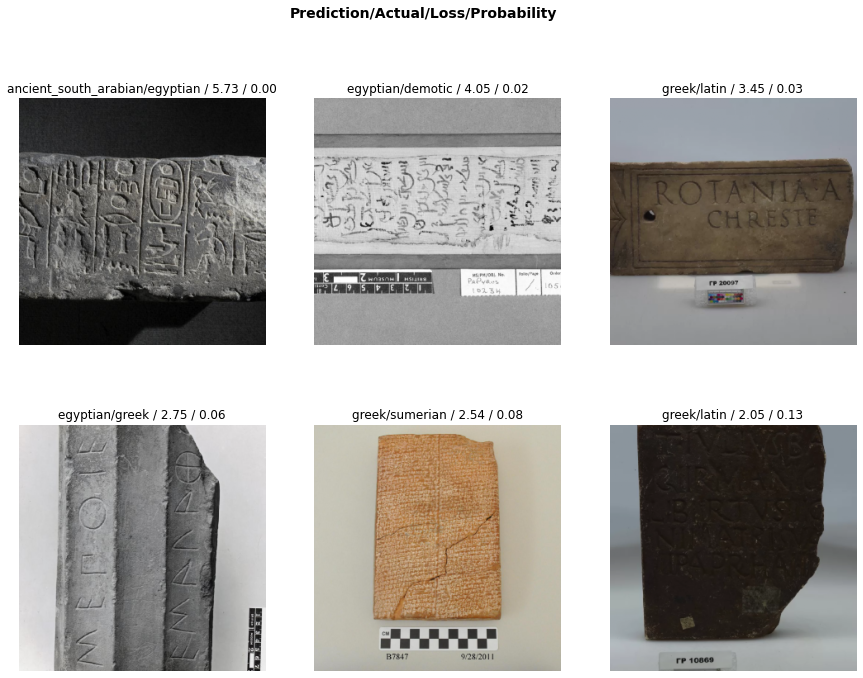

In [ ]:
interp.plot_top_losses(6, figsize=(15,11))

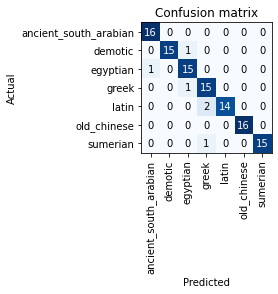

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
precision = 0
recall = 0
for i in range(0, 7):
    s = 0
    for j in range(0, 7):
        s += interp.confusion_matrix()[i][j]
    precision_i = interp.confusion_matrix()[i][i] / s
    precision += precision_i
    s = 0
    for j in range(0, 7):
        s += interp.confusion_matrix()[j][i]
    recall_i = interp.confusion_matrix()[i][i] / s
    recall += recall_i

precision = precision / 7
recall = recall / 7
print(precision, recall)

0.9464285714285714 0.9509803921568627


In [ ]:
f1score = 2 * (precision * recall) / (precision + recall)
f1score

0.9486990219597711

In [ ]:
num = 0
denom = 0
for i in range(0, 7):
    num += interp.confusion_matrix()[i][i]
    for j in range(0, 7):
        denom += interp.confusion_matrix()[i][j]

acc = num / denom
acc

0.9464285714285714

In [ ]:
precision = 0
recall = 0
num = 0
denom = 0
table = []
l = ["Южноаравийское письмо", "Демотическое письмо", "Египетский", "Греческий", "Латинский", "Древнекитайский", "Шумерский"]

for i in range(0, 7):
    num += interp.confusion_matrix()[i][i]
    s = 0
    for j in range(0, 7):
        s += interp.confusion_matrix()[i][j]
        denom += interp.confusion_matrix()[i][j]
    precision_i = interp.confusion_matrix()[i][i] / s
    precision += precision_i
    s = 0
    for j in range(0, 7):
        s += interp.confusion_matrix()[j][i]
    if s != 0:
        recall_i = interp.confusion_matrix()[i][i] / s
        recall += recall_i

        f1 = 2 * (precision_i * recall_i) / (precision_i + recall_i)

        table.append([l[i], precision_i, recall_i, f1])

df = DataFrame(table, columns = ["Язык", "precision", "recall", "F1-score"])

precision = precision / 7
recall = recall / 7
f1score = 2 * (precision * recall) / (precision + recall)
acc = num / denom
print('Accuracy =', acc)
print('Precision =', precision)
print('Recall =', recall)
print('F1-score =', f1score)
df

Accuracy = 0.9464285714285714
Precision = 0.9464285714285714
Recall = 0.9509803921568627
F1-score = 0.9486990219597711


,Язык,precision,recall,F1-score
0,Южноаравийское письмо,1.0000,0.941176,0.969697
1,Демотическое письмо,0.9375,1.000000,0.967742
2,Египетский,0.9375,0.882353,0.909091
3,Греческий,0.9375,0.833333,0.882353
4,Латинский,0.8750,1.000000,0.933333
5,Древнекитайский,1.0000,1.000000,1.000000
6,Шумерский,0.9375,1.000000,0.967742


In [ ]:
image = open_image('238947_big.jpg')

In [ ]:
learn.predict(image)[2]

tensor([6.5210e-02, 1.5111e-03, 5.3537e-04, 3.7204e-01, 5.5481e-01, 4.7691e-03,
        1.1239e-03])

In [ ]:
image = open_image('DemoticScriptsRosettaStoneReplica.jpg')
learn.predict(image)[2]

tensor([1.7913e-03, 1.7510e-05, 1.8503e-03, 3.6757e-02, 4.1833e-02, 9.1753e-01,
        2.2173e-04])